# Linear models, loss functions, gradients, SGD
(c) Deniz Yuret, 2019
* Objectives: Define, train and visualize a simple model; understand gradients and SGD; learn to use the GPU.
* Prerequisites: [Callable objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1), [Generator expressions](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions-1), [MNIST](20.mnist.ipynb), [Iterators](25.iterators.ipynb)
* New functions: 
[mnistdata](https://github.com/denizyuret/Knet.jl/blob/master/data/mnist.jl),
[accuracy](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.accuracy), 
[zeroone](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.zeroone), 
[nll](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.nll), 
[Param, @diff, value, params, grad](http://denizyuret.github.io/Knet.jl/latest/reference/#AutoGrad),
[sgd](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.sgd),
[progress, progress!](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.progress), 
[gpu](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.gpu), 
[KnetArray](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.KnetArray), 
[load](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.load), 
[save](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.save)


<img src="https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0401.png" alt="A linear model" width=300/> ([image source](https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/ch04.html))

In Knet, a machine learning model is defined using plain Julia code. A typical model consists of a **prediction** and a **loss** function. The prediction function takes some input, returns the prediction of the model for that input. The loss function measures how bad the prediction is with respect to some desired output. We train a model by adjusting its parameters to reduce the loss.

In this section we will implement a simple linear model to classify MNIST digits. The prediction function will return 10 scores for each of the possible labels 0..9 as a linear combination of the pixel values. The loss function will convert these scores to normalized probabilities and return the average -log probability of the correct answers. Minimizing this loss should maximize the scores assigned to correct answers by the model. We will make use of the loss gradient with respect to each parameter, which tells us the direction of the greatest loss increase. We will improve the model by moving the parameters in the opposite direction (using a GPU if available). We will visualize the model weights and performance over time. The final accuracy of about 92% is close to the limit of what we can achieve with this type of model. To improve further we must look beyond linear models.

In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","AutoGrad","IterTools","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
import Random # seed!
using Knet: Knet, AutoGrad, dir, Data, Param, @diff, value, params, grad, progress, progress!, gpu, KnetArray, load, save
# The following are defined for instruction even though they are provided in Knet
# using Knet: accuracy, zeroone, nll, sgd

In [2]:
# Load data (mnistdata basically replicates mnist.ipynb)
include(Knet.dir("data","mnist.jl"))
dtrn,dtst = mnistdata(xsize=(784,:),xtype=Array)
println.(summary.((dtrn,dtst)));

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/dyuret/.julia/dev/Knet/data/mnist.jl:33


600-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}
100-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}


## Model definition

In [3]:
# In Julia we define a new datatype using `struct`:
struct Linear; w; b; end

# The new struct comes with a default constructor:
model = Linear(0.01 * randn(10,784), zeros(10))

# We can define other constructors with different inputs:
Linear(i::Int,o::Int,scale=0.01) = Linear(scale * randn(o,i), zeros(o))

# This one allows instances to be defined using input and output sizes:
model = Linear(784,10)

Linear([-0.00930764 -1.73228e-5 … 0.00286358 0.00338102; -0.0154502 -0.00492697 … -0.00578297 -0.0168118; … ; -0.0135301 -0.0130993 … -0.0100258 -0.0010083; -0.0224418 0.00547202 … -0.00505807 0.00594477], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Prediction

In [4]:
# We turn Linear instances into callable objects for prediction:
(m::Linear)(x) = m.w * x .+ m.b

In [5]:
x,y = first(dtst) # The first minibatch from the test set
summary.((x,y))

("784×100 Array{Float32,2}", "100-element Array{UInt8,1}")

In [6]:
Int.(y)' # correct answers are given as an array of integers (remember we use 10 for 0)

1×100 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 7  2  1  10  4  1  4  9  5  9  …  1  3  6  9  3  1  4  1  7  6  9

In [7]:
ypred = model(x)  # Predictions on the first minibatch: a 10x100 score matrix

10×100 Array{Float64,2}:
 -0.00410484   0.021517    0.0135085  …  -0.0142226   -0.0172761  
 -0.0240913    0.0335927  -0.0706286      0.0791179    0.0736431  
  0.0932138   -0.057978   -0.0536457      0.105226    -0.0364376  
 -0.0585087    0.164165    0.0140825     -0.061517    -0.000969126
  0.00974735   0.105798   -0.0116878     -0.00833981   0.109366   
  0.0321055    0.0523192   0.107068   …   0.127174     0.134652   
 -0.11468     -0.0669171  -0.107339      -0.0710706   -0.16536    
 -0.0751655   -0.108038    0.0747432     -0.0961626   -0.0103486  
  0.117249     0.0954578   0.074709       0.0766856    0.294205   
 -0.0574604    0.0391589  -0.0471648      0.0195734   -0.0645414  

In [8]:
# We can calculate the accuracy of our model for the first minibatch
accuracy(model,x,y) = mean(y' .== map(i->i[1], findmax(Array(model(x)),dims=1)[2]))
accuracy(model,x,y)

0.13

In [9]:
# We can calculate the accuracy of our model for the whole test set
accuracy(model,data) = mean(accuracy(model,x,y) for (x,y) in data)
accuracy(model,dtst)

0.10329999999999999

In [10]:
# ZeroOne loss (or error) is defined as 1 - accuracy
zeroone(x...) = 1 - accuracy(x...)
zeroone(model,dtst)

0.8967

## Loss function

In [11]:
# For classification we use negative log likelihood loss (aka cross entropy, softmax loss, NLL)
# This is the average -log probability assigned to correct answers by the model
function nll(scores, y)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    answerprobs = (probabilities[y[i],i] for i in 1:length(y))
    mean(-log.(answerprobs))
end

nll (generic function with 1 method)

In [12]:
# model(x) gives predictions, let model(x,y) give the loss
(m::Linear)(x, y) = nll(m(x), y)
model(x,y)

2.308938079912147

In [13]:
# We can also use the Knet nll implementation for efficiency
(m::Linear)(x, y) = Knet.nll(m(x), y)
model(x,y)

2.308938079912147

In [14]:
# If the input is a dataset compute average loss:
(m::Linear)(data::Data) = mean(m(x,y) for (x,y) in data)

In [15]:
# Here is per-instance average negative log likelihood for the whole test set
model(dtst)

2.3096749652904793

**Bonus question:** What is special about the loss value 2.3?

## Calculating the gradient using AutoGrad

In [16]:
@doc AutoGrad

Usage:

```
x = Param([1,2,3])          # user declares parameters with `Param`
x => P([1,2,3])             # `Param` is just a struct wrapping a value
value(x) => [1,2,3]         # `value` returns the thing wrapped
sum(x .* x) => 14           # Params act like regular values
y = @diff sum(x .* x)       # Except when we differentiate using `@diff`
y => T(14)                  # you get another struct
value(y) => 14              # which carries the same result
params(y) => [x]            # and the Params that it depends on 
grad(y,x) => [2,4,6]        # and the gradients for all Params
```

`Param(x)` returns a struct that acts like `x` but marks it as a parameter you want to compute gradients with respect to.

`@diff expr` evaluates an expression and returns a struct that contains the result (which should be a scalar) and gradient information.

`grad(y, x)` returns the gradient of `y` (output by @diff) with respect to any parameter `x::Param`, or  `nothing` if the gradient is 0.

`value(x)` returns the value associated with `x` if `x` is a `Param` or the output of `@diff`, otherwise returns `x`.

`params(x)` returns an iterator of Params found by a recursive search of object `x`.

Alternative usage:

```
x = [1 2 3]
f(x) = sum(x .* x)
f(x) => 14
grad(f)(x) => [2 4 6]
gradloss(f)(x) => ([2 4 6], 14)
```

Given a scalar valued function `f`, `grad(f,argnum=1)` returns another function `g` which takes the same inputs as `f` and returns the gradient of the output with respect to the argnum'th argument. `gradloss` is similar except the resulting function also returns f's output.


In [17]:
# Redefine the constructor to use Param's so we can compute gradients
Linear(i::Int,o::Int,scale=0.01) = 
    Linear(Param(scale * randn(o,i)), Param(zeros(o)))

Linear

In [18]:
# Set random seed for replicability
Random.seed!(9);

In [19]:
# Use a larger scale to get a large initial loss
model = Linear(784,10,1.0)

Linear(P(Array{Float64,2}(10,784)), P(Array{Float64,1}(10)))

In [20]:
# We can still do predictions and calculate loss:
model(x,y)

19.10423456298375

In [21]:
# And we can do the same loss calculation also computing gradients:
J = @diff model(x,y)

T(19.10423456298375)

In [22]:
# To get the actual loss value from J:
value(J)

19.10423456298375

In [23]:
# params(J) returns an iterator of Params J depends on (i.e. model.b, model.w):
params(J) |> collect

2-element Array{Param,1}:
 P(Array{Float64,1}(10))    
 P(Array{Float64,2}(10,784))

In [24]:
# To get the gradient of a parameter from J:
∇w = grad(J,model.w)

10×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
# Note that each gradient has the same size and shape as the corresponding parameter:
@show ∇b = grad(J,model.b);

∇b = grad(J, model.b) = [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576]


## Checking the gradient using numerical approximation

What does ∇b represent?

∇b[10] = 0.79 means if I increase b[10] by ϵ, loss will increase by 0.79ϵ

In [26]:
# Loss for the first minibatch with the original parameters
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


19.10423456298375

In [27]:
# To numerically check the gradient let's increase the last entry of b by +0.1.
model.b[10] = 0.1

0.1

In [28]:
# We see that the loss moves by ≈ +0.79*0.1 as expected.
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]


19.183620170313954

In [29]:
# Reset the change.
model.b[10] = 0

0

## Checking the gradient using manual implementation

In [30]:
# Without AutoGrad we would have to define the gradients manually:
function nllgrad(model,x,y)
    scores = model(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    for i in 1:length(y); probabilities[y[i],i] -= 1; end
    dJds = probabilities / length(y)
    dJdw = dJds * x'
    dJdb = vec(sum(dJds,dims=2))
    dJdw,dJdb
end;

In [31]:
∇w2,∇b2 = nllgrad(model,x,y)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576])

In [32]:
∇w2 ≈ ∇w

true

In [33]:
∇b2 ≈ ∇b

true

## Training with Stochastic Gradient Descent (SGD)

In [34]:
# Here is a single SGD update:
function sgdupdate!(func, args; lr=0.1)
    fval = @diff func(args...)
    for param in params(fval)
        ∇param = grad(fval, param)
        param .-= lr * ∇param
    end
    return value(fval)
end

sgdupdate! (generic function with 1 method)

In [35]:
# We define SGD for a dataset as an iterator so that:
# 1. We can monitor and report the training loss
# 2. We can take snapshots of the model during training
# 3. We can pause/terminate training when necessary
sgd(func, data; lr=0.1) = 
    (sgdupdate!(func, args; lr=lr) for args in data)

sgd (generic function with 1 method)

In [36]:
# Let's train a model for 10 epochs to compare training speed on cpu vs gpu.
# progress!(itr) displays a progress bar when wrapped around an iterator like this:
# 2.94e-01  100.00%┣████████████████████┫ 6000/6000 [00:10/00:10, 592.96/s] 2.31->0.28
model = Linear(784,10)
@show model(dtst)
progress!(sgd(model, ncycle(dtrn,10)))
@show model(dtst);

model(dtst) = 2.313187215962106
3.03e-01  100.00%┣███████████████████┫ 6000/6000 [00:11/00:11, 544.04i/s]
model(dtst) = 0.28065356838012656


## Using the GPU

In [37]:
# The training would go a lot faster on a GPU:
# 2.94e-01  100.00%┣███████████████████┫ 6000/6000 [00:02/00:02, 2653.45/s]  2.31->0.28
# To work on a GPU, all we have to do is convert Arrays to KnetArrays:
if gpu() >= 0  # gpu() returns a device id >= 0 if there is a GPU, -1 otherwise
    atype = KnetArray{Float32}  # KnetArrays are stored and operated in the GPU
    dtrn,dtst = mnistdata(xsize=(784,:),xtype=atype)
    Linear(i::Int,o::Int,scale=0.01) = 
        Linear(Param(atype(scale * randn(o,i))), 
               Param(atype(zeros(o))))

    model = Linear(784,10)
    @show model(dtst)
    progress!(sgd(model,ncycle(dtrn,10)))
    @show model(dtst)
end;

model(dtst) = 2.3035536f0
3.03e-01  100.00%┣██████████████████┫ 6000/6000 [00:05/00:05, 1248.44i/s]
model(dtst) = 0.28049186f0



## Recording progress

In [38]:
function trainresults(file, model)
    if (print("Train from scratch? (~77s) "); readline()[1]=='y')
        # We will train 100 epochs (the following returns an iterator, does not start training)
        training = sgd(model, ncycle(dtrn,100))
        # We will snapshot model and train/test loss and errors
        snapshot() = (deepcopy(model),model(dtrn),model(dtst),zeroone(model,dtrn),zeroone(model,dtst))
        # Snapshot results once every epoch (still an iterator)
        snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
        # Run the snapshot/training iterator, reshape and save results as a 5x100 array
        lin = reshape(collect(flatten(snapshots)),(5,:))
        # Knet.save and Knet.load can be used to store models in files
        Knet.save(file,"results",lin)
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file", file)
        lin = Knet.load(file,"results")    
    end
    return lin
end

trainresults (generic function with 1 method)

In [39]:
# 2.43e-01  100.00%┣████████████████▉┫ 60000/60000 [00:44/00:44, 1349.13/s]
lin = trainresults("lin113.jld2",Linear(784,10));

Train from scratch? (~77s) stdin> y
2.29e-01  100.00%┣████████████████▉┫ 60000/60000 [01:07/01:07, 893.73i/s]


## Linear model shows underfitting

In [40]:
using Plots; default(fmt = :png)

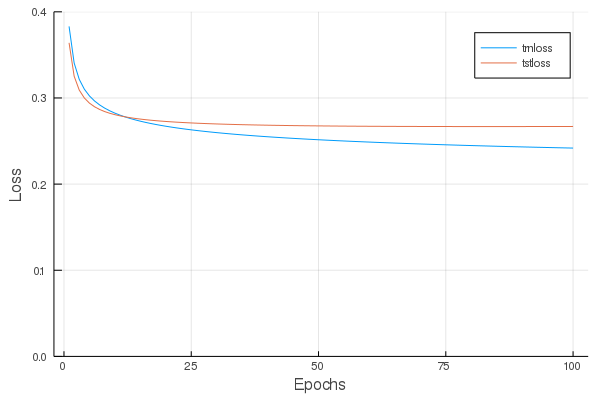

In [41]:
# Demonstrates underfitting: training loss not close to 0
# Also slight overfitting: test loss higher than train
trnloss,tstloss = Array{Float32}(lin[2,:]), Array{Float32}(lin[3,:]) 
plot([trnloss,tstloss],ylim=(.0,.4),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss")

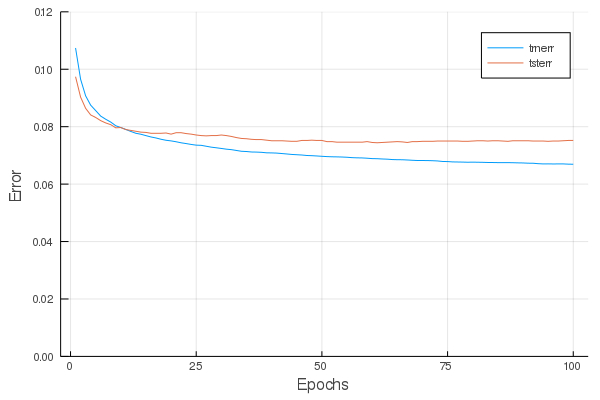

In [42]:
# this is the error plot, we get to about 7.5% test error, i.e. 92.5% accuracy
trnerr,tsterr = Array{Float32}(lin[4,:]), Array{Float32}(lin[5,:]) 
plot([trnerr,tsterr],ylim=(.0,.12),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")

## Visualizing the learned weights

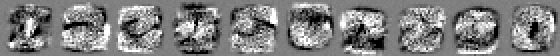

"Epoch 99"

In [43]:
# Let us visualize the evolution of the weight matrix as images below
# Each row is turned into a 28x28 image with positive weights light and negative weights dark gray
using Images, ImageMagick
for t in 10 .^ range(0,stop=log10(size(lin,2)),length=20) #logspace(0,2,20)
    i = ceil(Int,t)
    f = lin[1,i]
    w1 = reshape(Array(value(f.w))', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $(i-1)")
    sleep(1) # (0.96^i)
end